In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

dataset_path = '/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset'

Mounted at /content/drive


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import os 
import cv2
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg_preprocess
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/split_data/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/split_data/test'
val_path = '/content/drive/MyDrive/Colab Notebooks/split_data/val'

In [ ]:

labels = os.listdir(train_path)
print(labels)
for label in labels:
  print(label)
  print(labels.index(label))

['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
COVID
0
Normal
1
Viral Pneumonia
2
Lung_Opacity
3


In [ ]:
train_n_path = train_path+'/Normal/'
train_c_path = train_path+'/COVID/'
train_l_path = train_path+'/Lung_Opacity'
train_v_path = train_path+'/Viral Pneumonia/'

test_n_path = test_path+'/Normal/'
test_c_path = test_path+'/COVID/'
test_l_path = test_path+'/Lung_Opacity'
test_v_path = test_path+'/Viral Pneumonia/'

val_n_path = val_path+'/Normal/'
val_c_path = val_path+'/COVID/'
val_l_path = val_path+'/Lung_Opacity'
val_v_path = val_path+'/Viral Pneumonia/'

In [ ]:
print(f'Number of normal images is {len(os.listdir(train_n_path))}') #length of normal training images
print(f'Number of covid images is {len(os.listdir(train_c_path))}') #length of COVID training images 
print(f'Number of lung_opacity images is {len(os.listdir(train_l_path))}') #length of lung_opacity training images 
print(f'Number of pneumonia images is {len(os.listdir(train_v_path))}') #length of pneumonia training images 
print(f'Total training images is  {len(os.listdir(train_n_path)) + len(os.listdir(train_c_path)) + len(os.listdir(train_l_path)) + len(os.listdir(train_v_path))}')

Number of normal images is 8153
Number of covid images is 2892
Number of lung_opacity images is 4809
Number of pneumonia images is 1076
Total training images is  16930


In [ ]:
print(f'Number of normal images is {len(os.listdir(test_n_path))}') #length of normal test images
print(f'Number of covid images is {len(os.listdir(test_c_path))}') #length of COVID test images 
print(f'Number of lung_opacity images is {len(os.listdir(test_l_path))}') #length of lung_opacity test images 
print(f'Number of pneumonia images is {len(os.listdir(test_v_path))}') #length of pneumonia test images 
print(f'Total testing images is  {len(os.listdir(test_n_path)) + len(os.listdir(test_c_path)) + len(os.listdir(test_l_path)) + len(os.listdir(test_v_path))}')

Number of normal images is 1020
Number of covid images is 363
Number of lung_opacity images is 602
Number of pneumonia images is 135
Total testing images is  2120


In [ ]:
print(f'Number of normal images is {len(os.listdir(val_n_path))}') #length of normal val images
print(f'Number of covid images is {len(os.listdir(val_c_path))}') #length of COVID val images 
print(f'Number of lung_opacity images is {len(os.listdir(val_l_path))}') #length of lung_opacity val images 
print(f'Number of pneumonia images is {len(os.listdir(val_v_path))}') #length of pneumonia val images 
print(f'Total testing images is  {len(os.listdir(val_n_path)) + len(os.listdir(val_c_path)) + len(os.listdir(val_l_path)) + len(os.listdir(val_v_path))}')

Number of normal images is 1019
Number of covid images is 361
Number of lung_opacity images is 601
Number of pneumonia images is 134
Total testing images is  2115


In [ ]:
img_size = 224

In [ ]:
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data(train_path)
test = get_training_data(test_path)
val = get_training_data(val_path)

<ipython-input-12-226148560195>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [ ]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras import optimizers


model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:

train_datagen = ImageDataGenerator(
    #preprocessing_function=vgg_preprocess,
    rescale = 1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    shuffle=False)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 30, 
    zoom_range = 0.2,  
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    horizontal_flip = True, 
)

In [ ]:
train_datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 4, activation = 'softmax'))

model.compile(
              optimizer = 'adam', loss = 'categorical_crossentropy', 
              metrics = ['accuracy']
              )

In [ ]:
train_n_path = train_path+'/Normal/'
train_c_path = train_path+'/COVID/'
train_l_path = train_path+'/Lung_Opacity'
train_v_path = train_path+'/Viral Pneumonia/'

total = len(os.listdir(train_n_path)) + len(os.listdir(train_c_path)) + len(os.listdir(train_l_path)) + len(os.listdir(train_v_path))

covid = len(os.listdir(train_c_path))
normal = len(os.listdir(train_n_path))
viral = len(os.listdir(train_v_path))
lung_opacity = len(os.listdir(train_l_path))


weight_for_c = 1/covid * (total/4.0)
weight_for_n = 1/normal * (total/4.0)
weight_for_v = 1/viral * (total/4.0)
weight_for_l = 1/lung_opacity * (total/4.0)

class_weight = {0:weight_for_c, 1:weight_for_n, 2:weight_for_v, 3:weight_for_l}
class_weight

{0: 1.4635200553250347,
 1: 0.5191340610818104,
 2: 3.9335501858736057,
 3: 0.880120607194843}

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [ ]:
import keras.utils as ku

In [ ]:

y_train = ku.to_categorical(y_train, 4)
y_test = ku.to_categorical(y_test, 4)

In [ ]:
y_val = ku.to_categorical(y_val, 4)

In [ ]:
# Start training the model
history = model.fit(train_datagen.flow(x_train, y_train, batch_size = 32), 
                    epochs = 25, validation_data = train_datagen.flow(x_val, y_val), 
                    callbacks = [learning_rate_reduction], class_weight = class_weight)

Epoch 1/25
530/530 [==============================] - 194s 339ms/step - loss: 1.1209 - accuracy: 0.5008 - val_loss: 2.3531 - val_accuracy: 0.3078 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - 184s 347ms/step - loss: 0.8376 - accuracy: 0.5488 - val_loss: 1.0822 - val_accuracy: 0.5026 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - 184s 348ms/step - loss: 0.7381 - accuracy: 0.6080 - val_loss: 1.4559 - val_accuracy: 0.4790 - lr: 0.0010
Epoch 4/25
530/530 [==============================] - 183s 345ms/step - loss: 0.7115 - accuracy: 0.6414 - val_loss: 0.9231 - val_accuracy: 0.6189 - lr: 0.0010
Epoch 5/25
530/530 [==============================] - 183s 346ms/step - loss: 0.6422 - accuracy: 0.6914 - val_loss: 0.9277 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 6/25
530/530 [==============================] - 183s 346ms/step - loss: 0.5951 - accuracy: 0.7172 - val_loss: 0.8684 - val_accuracy: 0.6303 - lr: 0.0010
Epoch 7/25
530/530 [==========================

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/baseline.h5')

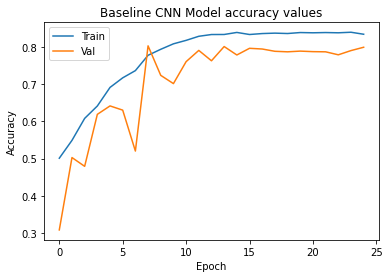

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Baseline CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

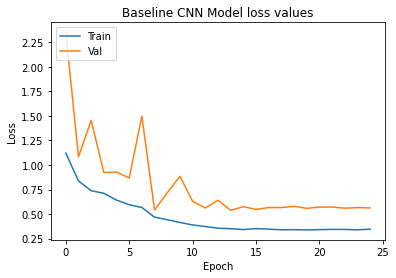

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Baseline CNN Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 1s 9ms/step


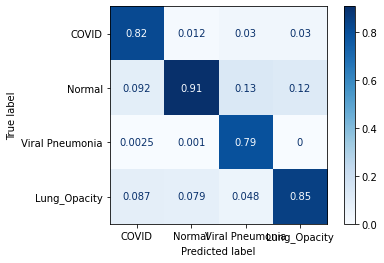

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/baseline.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

          COVID       0.82      0.91      0.86       363
         Normal       0.91      0.88      0.89      1020
Viral Pneumonia       0.79      0.99      0.88       135
   Lung_Opacity       0.85      0.80      0.82       602

       accuracy                           0.87      2120
      macro avg       0.84      0.89      0.86      2120
   weighted avg       0.87      0.87      0.87      2120



In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1/255
)

In [ ]:
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
     

Found 16930 images belonging to 4 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2120 images belonging to 4 classes.


In [ ]:
val_set = test_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2115 images belonging to 4 classes.


In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/mymodel_1.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history=model.fit(
  train_datagen.flow(x_train, y_train, batch_size = 32), epochs = 25, validation_data = train_datagen.flow(x_val, y_val),  class_weight = class_weight, callbacks = callbacks,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.7180
Epoch 1: val_loss improved from inf to 0.60239, saving model to /content/drive/MyDrive/Colab Notebooks/mymodel_1.h5
530/530 [==============================] - 185s 347ms/step - loss: 0.6370 - accuracy: 0.7180 - val_loss: 0.6024 - val_accuracy: 0.7939 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.5148 - accuracy: 0.7766
Epoch 2: val_loss improved from 0.60239 to 0.59831, saving model to /content/drive/MyDrive/Colab Notebooks/mymodel_1.h5
530/530 [==============================] - 184s 348ms/step - loss: 0.5148 - accuracy: 0.7766 - val_loss: 0.5983 - val_accuracy: 0.7712 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.7937
Epoch 3: val_loss improved from 0.59831 to 0.50032, saving model to /content/drive/MyDrive/Colab Notebooks/mymodel_1.h5
530/530 [==============================] - 183s 345ms/step -

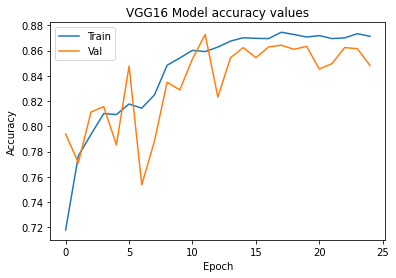

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('VGG16 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

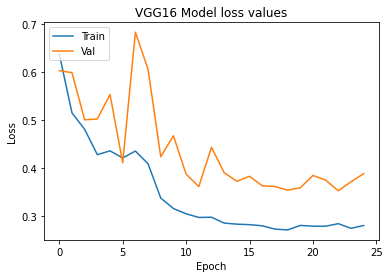

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('VGG16 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 2s 22ms/step


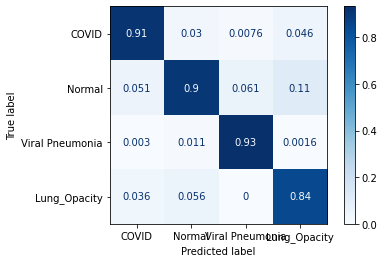

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/mymodel_1.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
score = test_model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 2s 19ms/step - loss: 0.3133 - accuracy: 0.8882
Test loss: 0.31327584385871887
Test accuracy: 0.8882075548171997


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

          COVID       0.91      0.83      0.87       363
         Normal       0.90      0.91      0.91      1020
Viral Pneumonia       0.93      0.90      0.92       135
   Lung_Opacity       0.84      0.89      0.86       602

       accuracy                           0.89      2120
      macro avg       0.90      0.88      0.89      2120
   weighted avg       0.89      0.89      0.89      2120



In [ ]:
IMAGE_SIZE = [224, 224]
vgg_trainable = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg_trainable.trainable = True

# Retrain the last 3 layers (all lower layers will be kept frozen)
for layer in vgg_trainable.layers[:-3]:
    layer.trainable = False

x_trainable = Flatten()(vgg_trainable.output)
prediction = Dense(4, activation='softmax')(x_trainable)
model_trainable = Model(inputs=vgg_trainable.input, outputs=prediction)
model_trainable.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_trainable.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/mymodel_2.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history=model_trainable.fit(
  train_datagen.flow(x_train, y_train, batch_size = 32), epochs = 25, validation_data = train_datagen.flow(x_val, y_val),  class_weight = class_weight, callbacks = callbacks,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.7771 - accuracy: 0.6568
Epoch 1: val_loss improved from inf to 0.88150, saving model to /content/drive/MyDrive/Colab Notebooks/mymodel_2.h5
530/530 [==============================] - 186s 348ms/step - loss: 0.7771 - accuracy: 0.6568 - val_loss: 0.8815 - val_accuracy: 0.6274 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.7721
Epoch 2: val_loss improved from 0.88150 to 0.56005, saving model to /content/drive/MyDrive/Colab Notebooks/mymodel_2.h5
530/530 [==============================] - 182s 344ms/step - loss: 0.5059 - accuracy: 0.7721 - val_loss: 0.5600 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.7980
Epoch 3: val_loss did not improve from 0.56005
530/530 [==============================] - 183s 345ms/step - loss: 0.4419 - accuracy: 0.7980 - val_loss: 0.6160 - val_accuracy: 0.772

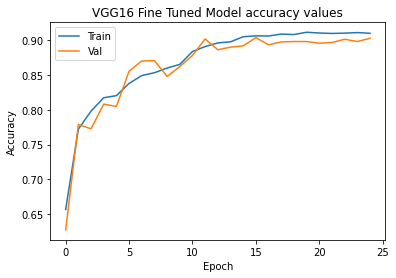

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('VGG16 Fine Tuned Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

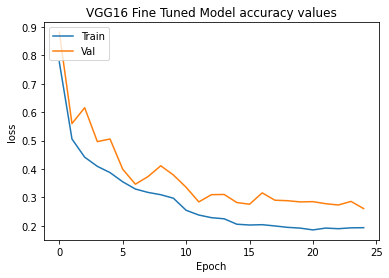

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('VGG16 Fine Tuned Model accuracy values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 1s 18ms/step


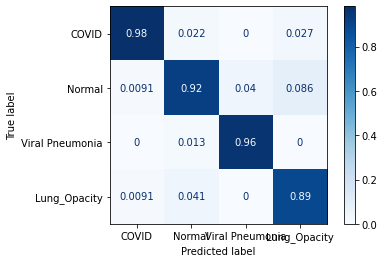

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/mymodel_2.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
score = test_model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 2s 20ms/step - loss: 0.2115 - accuracy: 0.9236
Test loss: 0.211457297205925
Test accuracy: 0.9235848784446716


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/mymodel_2.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
print(classification_report(y_test_conf, y_prediction, target_names=labels))

67/67 [==============================] - 10s 26ms/step
                 precision    recall  f1-score   support

          COVID       0.98      0.89      0.93       363
         Normal       0.92      0.94      0.93      1020
Viral Pneumonia       0.96      0.90      0.93       135
   Lung_Opacity       0.89      0.92      0.90       602

       accuracy                           0.92      2120
      macro avg       0.94      0.91      0.92      2120
   weighted avg       0.93      0.92      0.92      2120



In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/mymodel.h5')
score = test_model.evaluate(val_set, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 942s 14s/step - loss: 1.4797 - accuracy: 0.7645
Test loss: 1.479682207107544
Test accuracy: 0.7645390033721924


In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/mymodel_2.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit(
  train_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=50,
  validation_steps=32,
  callbacks = callbacks,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
50/50 [==============================] - ETA: 0s - loss: 4.2255 - accuracy: 0.5019
Epoch 1: val_loss improved from inf to 2.96699, saving model to /content/drive/MyDrive/Colab Notebooks/mymodel_2.h5
50/50 [==============================] - 47s 930ms/step - loss: 4.2255 - accuracy: 0.5019 - val_loss: 2.9670 - val_accuracy: 0.6162
Epoch 2/25
50/50 [==============================] - ETA: 0s - loss: 2.9860 - accuracy: 0.6212
Epoch 2: val_loss improved from 2.96699 to 2.55048, saving model to /content/drive/MyDrive/Colab Notebooks/mymodel_2.h5
50/50 [==============================] - 49s 981ms/step - loss: 2.9860 - accuracy: 0.6212 - val_loss: 2.5505 - val_accuracy: 0.6787
Epoch 3/25
50/50 [==============================] - ETA: 0s - loss: 2.2604 - accuracy: 0.6781
Epoch 3: val_loss improved from 2.55048 to 2.10569, saving model to /content/drive/MyDrive/Colab Notebooks/mymodel_2.h5
50/50 [==============================] - 47s 947ms/step - loss: 2.2604 - accuracy: 0.6781 - val_lo

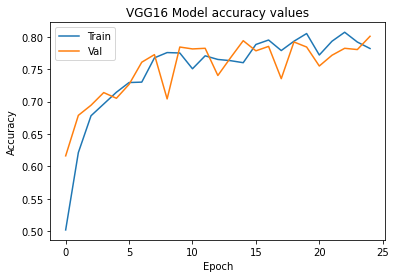

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('VGG16 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

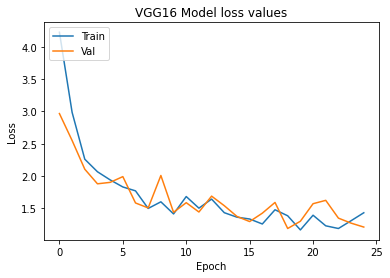

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('VGG16 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/mymodel_2.h5')
score = test_model.evaluate(val_set, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 515s 8s/step - loss: 1.2856 - accuracy: 0.7929
Test loss: 1.2855697870254517
Test accuracy: 0.7929077744483948


67/67 [==============================] - 513s 8s/step


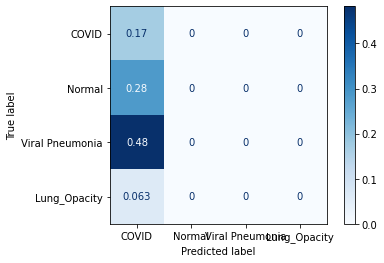

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/mymodel_2.h5')
y_prediction = test_model.predict(val_set)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
result = confusion_matrix(val_set.classes, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_set.classes, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

          COVID       0.17      1.00      0.29       361
         Normal       0.00      0.00      0.00       601
Viral Pneumonia       0.00      0.00      0.00      1019
   Lung_Opacity       0.00      0.00      0.00       134

       accuracy                           0.17      2115
      macro avg       0.04      0.25      0.07      2115
   weighted avg       0.03      0.17      0.05      2115



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
img_size = 224

In [ ]:
# Model setup
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 4, activation = 'softmax'))

model.compile(
              optimizer = 'adam', loss = 'categorical_crossentropy', 
              metrics = ['accuracy']
              )

In [ ]:
history = model.fit(train_set, 
                    epochs = 25, validation_data = val_set, )

Epoch 1/25
  2/530 [..............................] - ETA: 1:04:28 - loss: 6.5831 - accuracy: 0.4531

KeyboardInterrupt: ignored

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/mymodel_3.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit(
  train_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=50,
  validation_steps=32,
  callbacks = callbacks,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

NameError: ignored

In [ ]:
base_model = ResNet50V2(input_shape = [224, 224, 3] ,weights='imagenet', include_top=False)

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
num_classes = 4
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
res_train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

res_test_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
res_train_set = res_train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"],
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

res_test_set = res_test_datagen.flow_from_directory(test_path,
                                                 target_size = (224, 224),
                                                 classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"],
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
res_val_set = res_test_datagen.flow_from_directory(val_path,
                                                 target_size = (224, 224),
                                                 classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"],
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 16930 images belonging to 4 classes.
Found 2120 images belonging to 4 classes.
Found 2115 images belonging to 4 classes.


(32, 224, 224, 3)


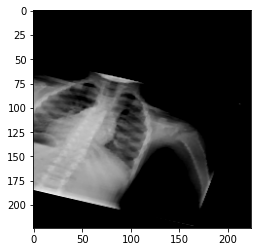

(32, 224, 224, 3)


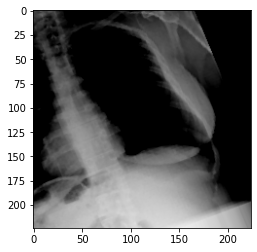

(32, 224, 224, 3)


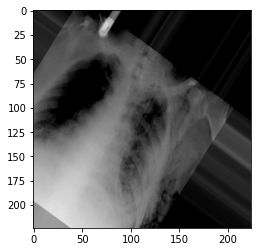

(32, 224, 224, 3)


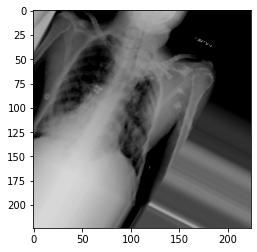

(32, 224, 224, 3)


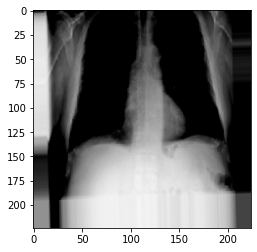

In [ ]:
for _ in range(5):
    img, label = res_val_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/resnet_model_2.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit(
  res_train_set,
  validation_data=res_val_set,
  epochs=25,
  callbacks = callbacks,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
530/530 [==============================] - ETA: 0s - loss: 4.1862 - accuracy: 0.7455
Epoch 1: val_loss improved from inf to 5.61462, saving model to /content/drive/MyDrive/Colab Notebooks/resnet_model_1.h5
530/530 [==============================] - 274s 512ms/step - loss: 4.1862 - accuracy: 0.7455 - val_loss: 5.6146 - val_accuracy: 0.7778
Epoch 2/10
530/530 [==============================] - ETA: 0s - loss: 4.7855 - accuracy: 0.7827
Epoch 2: val_loss improved from 5.61462 to 4.69931, saving model to /content/drive/MyDrive/Colab Notebooks/resnet_model_1.h5
530/530 [==============================] - 269s 508ms/step - loss: 4.7855 - accuracy: 0.7827 - val_loss: 4.6993 - val_accuracy: 0.7915
Epoch 3/10
530/530 [==============================] - ETA: 0s - loss: 5.1959 - accuracy: 0.7858
Epoch 3: val_loss did not improve from 4.69931
530/530 [==============================] - 266s 502ms/step - loss: 5.1959 - accuracy: 0.7858 - val_loss: 4.9877 - val_accuracy: 0.7631
Epoch 4/10
530

In [ ]:
score = model.evaluate(res_test_set, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 32s 473ms/step - loss: 6.3258 - accuracy: 0.8160
Test loss: 6.325819969177246
Test accuracy: 0.8160377144813538


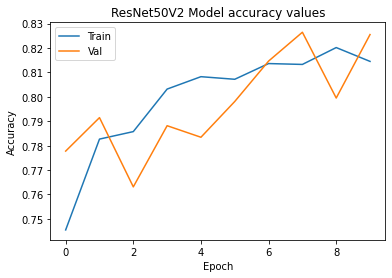

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('ResNet50V2 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

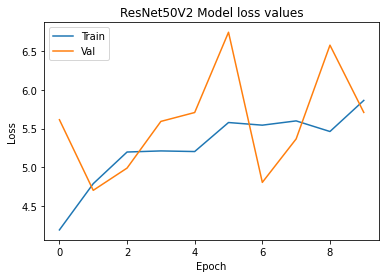

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('ResNet50V2 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
base_model = ResNet101V2(input_shape = [224, 224, 3] ,weights='imagenet', include_top=False)
num_classes = 4
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction)
model.summary()

171317808/171317808 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/resnet_model_2.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history_resnet=model.fit(
  train_datagen.flow(x_train, y_train),
  validation_data=train_datagen.flow(x_val, y_val),
  epochs=25,
  callbacks = callbacks,
  class_weight = class_weight,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 3.8625 - accuracy: 0.7092
Epoch 1: val_loss improved from inf to 6.50217, saving model to /content/drive/MyDrive/Colab Notebooks/resnet_model_2.h5
530/530 [==============================] - 193s 351ms/step - loss: 3.8625 - accuracy: 0.7092 - val_loss: 6.5022 - val_accuracy: 0.6799 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 3.8791 - accuracy: 0.7662
Epoch 2: val_loss improved from 6.50217 to 4.17515, saving model to /content/drive/MyDrive/Colab Notebooks/resnet_model_2.h5
530/530 [==============================] - 188s 355ms/step - loss: 3.8791 - accuracy: 0.7662 - val_loss: 4.1752 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 3.9045 - accuracy: 0.7766
Epoch 3: val_loss did not improve from 4.17515
530/530 [==============================] - 183s 346ms/step - loss: 3.9045 - accuracy: 0.7766 - val_loss: 6.7331 - val_accur

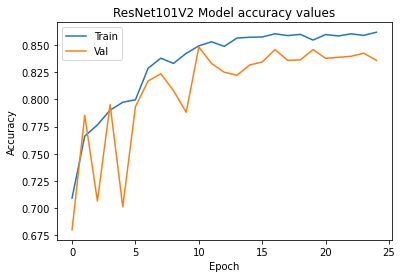

In [ ]:
plt.plot(model_history_resnet.history['accuracy'])
plt.plot(model_history_resnet.history['val_accuracy'])
plt.title('ResNet101V2 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

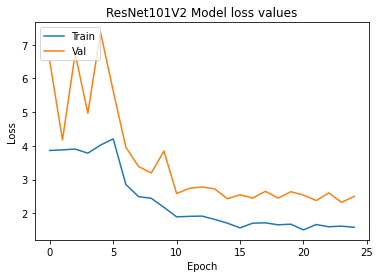

In [ ]:
plt.plot(model_history_resnet.history['loss'])
plt.plot(model_history_resnet.history['val_loss'])
plt.title('ResNet101V2 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 4s 35ms/step


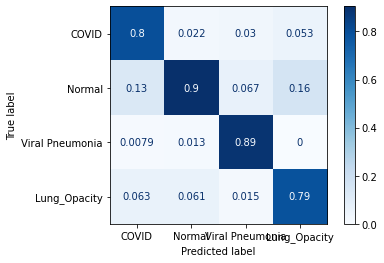

In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/resnet_model_2.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/resnet_model_2.h5')
score = test_model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 4s 27ms/step - loss: 1.9893 - accuracy: 0.8476
Test loss: 1.989336371421814
Test accuracy: 0.8476415276527405


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/resnet_model_2.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test_conf=np.argmax(y_test, axis=1)
print(classification_report(y_test_conf, y_prediction, target_names=labels))

67/67 [==============================] - 4s 24ms/step
                 precision    recall  f1-score   support

          COVID       0.80      0.83      0.81       363
         Normal       0.90      0.84      0.87      1020
Viral Pneumonia       0.89      0.89      0.89       135
   Lung_Opacity       0.79      0.86      0.82       602

       accuracy                           0.85      2120
      macro avg       0.84      0.86      0.85      2120
   weighted avg       0.85      0.85      0.85      2120



In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
res_trainable = ResNet101V2(input_shape = [224, 224, 3] ,weights='imagenet', include_top=False)
num_classes = 4
res_trainable.trainable = True
for layer in res_trainable.layers[:-10]:
    layer.trainable = False
x = Flatten()(res_trainable.output)
prediction = Dense(num_classes, activation='softmax')(x)
fine_resnet_model = Model(inputs=res_trainable.input, outputs=prediction)
fine_resnet_model.summary()


171317808/171317808 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
fine_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/resnet_model_3.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history_fine_resnet=fine_resnet_model.fit(
  train_datagen.flow(x_train, y_train),
  validation_data=train_datagen.flow(x_val, y_val),
  epochs=25,
  callbacks = callbacks,
  class_weight = class_weight,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.8437 - accuracy: 0.7144
Epoch 1: val_loss improved from inf to 1.44184, saving model to /content/drive/MyDrive/Colab Notebooks/resnet_model_3.h5
530/530 [==============================] - 200s 346ms/step - loss: 0.8437 - accuracy: 0.7144 - val_loss: 1.4418 - val_accuracy: 0.6671 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.7805
Epoch 2: val_loss improved from 1.44184 to 0.66243, saving model to /content/drive/MyDrive/Colab Notebooks/resnet_model_3.h5
530/530 [==============================] - 186s 352ms/step - loss: 0.5136 - accuracy: 0.7805 - val_loss: 0.6624 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.8099
Epoch 3: val_loss improved from 0.66243 to 0.50515, saving model to /content/drive/MyDrive/Colab Notebooks/resnet_model_3.h5
530/530 [==============================] - 18

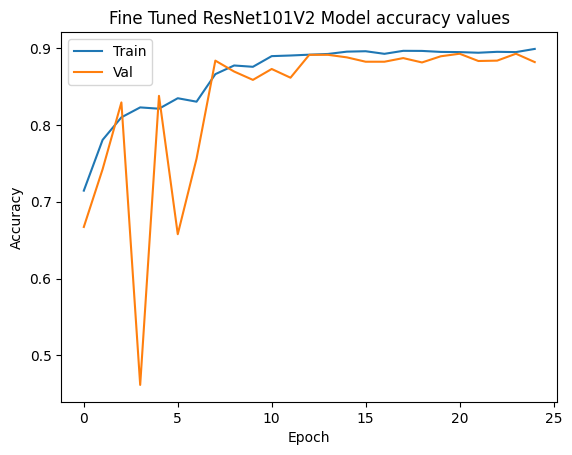

In [ ]:
plt.plot(model_history_fine_resnet.history['accuracy'])
plt.plot(model_history_fine_resnet.history['val_accuracy'])
plt.title('Fine Tuned ResNet101V2 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

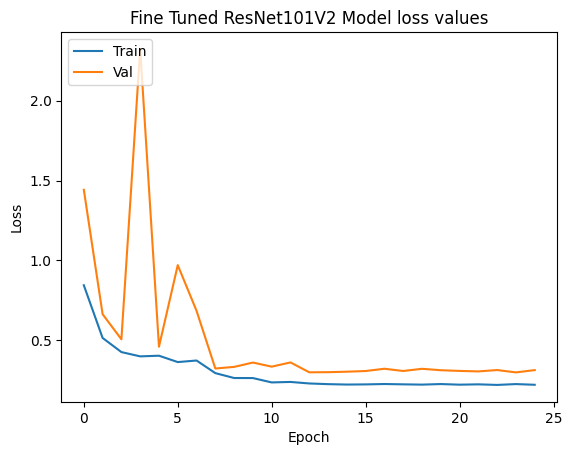

In [ ]:
plt.plot(model_history_fine_resnet.history['loss'])
plt.plot(model_history_fine_resnet.history['val_loss'])
plt.title('Fine Tuned ResNet101V2 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 3s 25ms/step


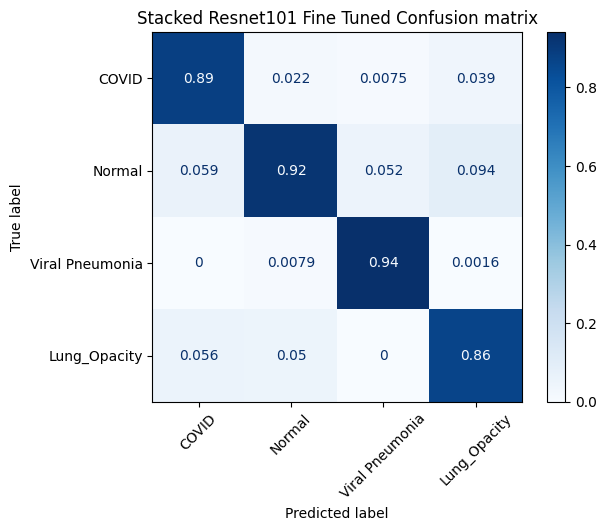

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/resnet_model_3.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Stacked Resnet101 Fine Tuned Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/resnet_model_3.h5')
score = test_model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 4s 27ms/step - loss: 0.2727 - accuracy: 0.8995
Test loss: 0.272712379693985
Test accuracy: 0.8995283246040344


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

          COVID       0.89      0.87      0.88       363
         Normal       0.92      0.92      0.92      1020
Viral Pneumonia       0.94      0.93      0.94       135
   Lung_Opacity       0.86      0.88      0.87       602

       accuracy                           0.90      2120
      macro avg       0.90      0.90      0.90      2120
   weighted avg       0.90      0.90      0.90      2120

